In [52]:
import torch
import math
from tycho2 import tycho2

def convert_to_cartesian(distances, ra, dec):
    x = distances * torch.cos(dec) * torch.cos(ra)
    y = distances * torch.cos(dec) * torch.sin(ra)
    z = distances * torch.sin(dec)
    return torch.stack((x, y, z), dim=1)

def calculate_distances(coords):
    dist_matrix = torch.cdist(coords, coords)
    unique_distances = torch.unique(dist_matrix)
    return unique_distances[unique_distances > 0]

def distance_from_magnitude(m, M):
    return 10**((m - M + 5) / 5)

def distance_from_magnitude_tensor(m: torch.Tensor, M: torch.Tensor) -> torch.Tensor:
    return 10**((m - M + 5) / 5)

# one of the possibilities
def tetrahedron_score(coords):
    distances = calculate_distances(coords)
    print(distances)
    mean_distance = torch.mean(distances)
    std_dev = torch.std(distances)

    # Assuming std_dev is small enough, the score will be close to 1
    # Otherwise, it will be closer to 0
    score = math.exp(-std_dev.item() / mean_distance.item())
    return score

# go from tycho2 to xyz coords
def transform_radecmag_from_numpy(stars):
    torch_tensors = [torch.from_numpy(star) for star in stars]
    zeroes = torch.zeros(len(torch_tensors[2]))
    print("one ", torch_tensors)
    torch_tensors[2] = distance_from_magnitude_tensor(torch_tensors[2], zeroes)
    print("two", torch_tensors)
    coords = convert_to_cartesian(*torch_tensors)
    return coords

def global_normalize_tensor(tensor):
    """Normalize a tensor based on its global min and max values. Also works for multiple tensors"""
    global_min = torch.min(tensor)
    global_max = torch.max(tensor)
    
    normalized = (tensor - global_min) / (global_max - global_min)
    return normalized

# Your tensor
    

In [53]:

# Define your input data
mag = torch.tensor([10, 15, 20, 25], dtype=torch.float32)
ra = torch.tensor([0.5, 1.0, 1.5, 2.0], dtype=torch.float32)
dec = torch.tensor([0.3, 0.6, 0.9, 1.2], dtype=torch.float32)

coords = convert_to_cartesian(mag, ra, dec)
score = tetrahedron_score(coords)

print("Tetrahedron score:", score)

coords = torch.tensor([
    [0.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [0.5, math.sqrt(3) / 2, 0.0],
    [0.5, math.sqrt(3) / 6, math.sqrt(2 / 3)]
], dtype=torch.float32)
print(coords)
score = tetrahedron_score(coords)

print("Tetrahedron score:", score)

tensor([ 8.2071,  9.4594,  9.8609, 16.7051, 18.2786, 23.9800])
Tetrahedron score: 0.6480581912392962
tensor([[0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [0.5000, 0.8660, 0.0000],
        [0.5000, 0.2887, 0.8165]])
tensor([1.])
Tetrahedron score: nan


In [54]:
tycho = tycho2('tyc2index.npy', 'tyc2.npy', 'tyc2sup.npy' )

In [55]:
stars = tycho.stars_within_radius([50,5], 2,15)
print(f"We have {len(stars[0])} stars")

We have 1523 stars


In [56]:
coords = transform_radecmag_from_numpy(stars)
print(coords)

one  [tensor([5.8374, 5.8626, 5.8472,  ..., 5.8728, 5.7736, 5.7371]), tensor([-1.2562, -1.2524, -1.2615,  ..., -1.3093, -1.3285, -1.3498]), tensor([ 9.6560,  9.3680,  9.2730,  ...,  8.8450, 10.5710, 12.4970])]
two [tensor([5.8374, 5.8626, 5.8472,  ..., 5.8728, 5.7736, 5.7371]), tensor([-1.2562, -1.2524, -1.2615,  ..., -1.3093, -1.3285, -1.3498]), tensor([ 853.4931,  747.4807,  715.4841,  ...,  587.4894, 1300.7688,
        3157.9111])]
tensor([[ 0.9453, -2.9047, -4.9744],
        [ 1.7919, -5.4356, -1.2699],
        [ 1.2414, -3.8842, -4.1907],
        ...,
        [-1.5184,  5.6727, -0.0682],
        [ 1.3701, -5.5424,  0.8596],
        [-1.0304,  4.5864, -3.2890]])


In [57]:
norm_coords = global_normalize_tensor(coords)
print(norm_coords)
coords = norm_coords

tensor([[0.5766, 0.2686, 0.1031],
        [0.6443, 0.0662, 0.3994],
        [0.6003, 0.1903, 0.1658],
        ...,
        [0.3795, 0.9547, 0.4955],
        [0.6106, 0.0577, 0.5697],
        [0.4186, 0.8678, 0.2379]])


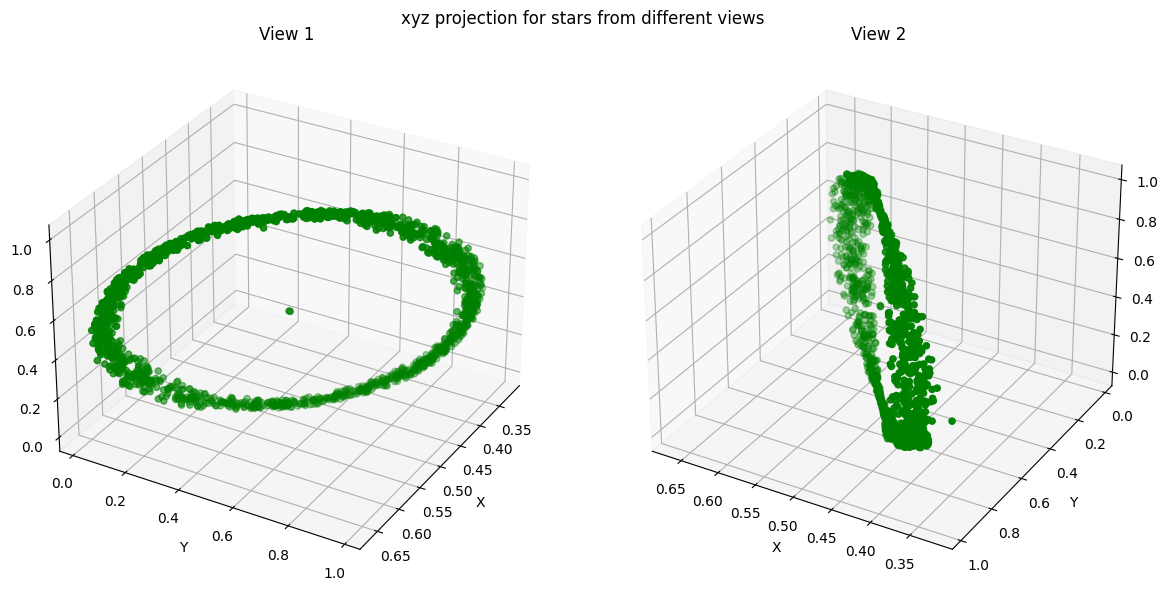

In [59]:
# importing mplot3d toolkits
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])  # set width ratio for each subplot

# First subplot with one viewing angle
ax1 = fig.add_subplot(gs[0], projection='3d')
ax1.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c='green')
ax1.view_init(30, 30)  # Set elevation and azimuth
ax1.set_title('View 1')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Second subplot with another viewing angle
ax2 = fig.add_subplot(gs[1], projection='3d')
ax2.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c='green')
ax2.view_init(30, 120)  # Different elevation and azimuth
ax2.set_title('View 2')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.suptitle('xyz projection for stars from different views')
plt.tight_layout()
plt.show()